In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

%matplotlib inline

In [9]:
file_path = r'C:\Users\Gebruiker\OneDrive\Documents\09 Ironhack\07 Bootcamp\05 Week 5 - EDA and Inferential Stats\02 W5 - Codes\amz_uk_price_prediction_dataset.csv'
df = pd.read_csv(file_path)
df = df.copy()
df.head(3)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers


### Part 1: Analyzing Best-Seller Trends Across Product Categories

Objective: Understand the relationship between product categories and their best-seller status.

#### 1.1. Crosstab Analysis:

- Create a crosstab between the product category and the isBestSeller status.

- Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

In [16]:
# Generating a crosstab for 'category' and 'isBestSeller'
crosstab_result = pd.crosstab(df['category'], df['isBestSeller']).sort_values(by=True, ascending=False)

crosstab_result

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
...,...,...
Downhill Ski Boots,1284,0
Digital Frames,774,0
Motorbike Chassis,107,0


In [11]:
# the other option
crosstab_result['Proportion'] = crosstab_result[True]/(crosstab_result[True] + crosstab_result[False])

crosstab_result_sorted = crosstab_result.sort_values(by='Proportion', ascending=False)
crosstab_result_sorted

isBestSeller,False,True,Proportion
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
...,...,...,...
Vases,250,0,0.000000
Blank Media Cases & Wallets,243,0,0.000000
Bedding Collections,6309,0,0.000000


#### 1.2. Statistical Tests:

- Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.

- Compute Cramér's V to understand the strength of association between best-seller status and category.

In [13]:
# Null hypothesis: best-seller distribution is independent of category

# Chi-square test
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result) # _, _ is for the return of running the code. We just tell python that we will place those returns there. But we dont care about it.

print('p value:', chi2_p_value)


p value: 0.0


In [17]:
crosstab_result

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
...,...,...
Downhill Ski Boots,1284,0
Digital Frames,774,0
Motorbike Chassis,107,0


In [18]:
# Cramer's V
cramer_result = association(crosstab_result, method="cramer")

print("Cramer's V value:", cramer_result)

Cramer's V value: 0.12228294397605641


The p value of 0 means that we need to reject the null hypothesis which in other words, there is relationship between those two variables.
The df is 2 because the dataframe has 3 columns. The Cramer value of 0.12 suggests a weak association between both variables. 

#### 1.3. Visualizations:

Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

In [25]:
top_category = crosstab_result.head(10)
top_category

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
Beauty,19010,302
Pet Supplies,9152,285
Arts & Crafts,9319,230
Women,17559,213


<Axes: xlabel='category'>

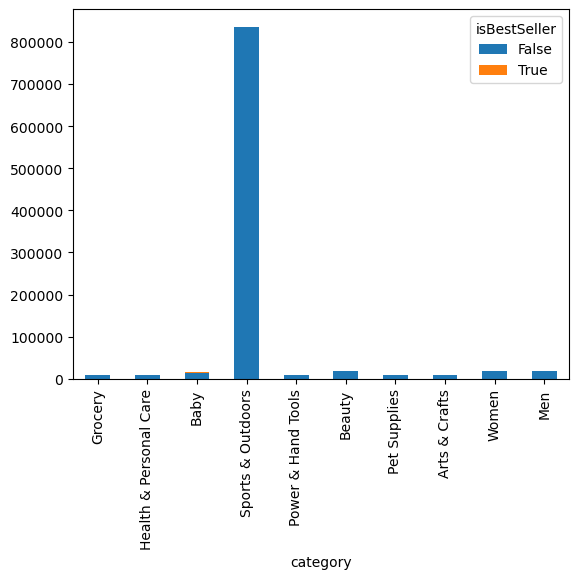

In [24]:
# Plotting a stacked bar chart for the 'crosstab_result' data
top_category.plot(kind="bar", stacked=True)

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

Objective: Investigate how different product categories influence product prices.

Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

**(From check for understanding)** <br>
Tukey's test for outliers involves using the interquartile range (IQR) to determine if values are outliers. While there isn't a direct "Tukey's test" function in Python's standard libraries, you can easily compute it using the IQR.

Here's how you can perform Tukey's test for outliers:

1. Calculate the first quartile (Q1) and third quartile (Q3) for the data.
2. Compute the interquartile range: \( \text{IQR} = Q3 - Q1 \).
3. Identify outliers:
   - Values less than \( Q1 - 1.5 \times \text{IQR} \)
   - Values greater than \( Q3 + 1.5 \times \text{IQR} \)

Here's a Python function that implements Tukey's test for outliers:

In [26]:
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers

In [27]:
data_series = df['price']  
outliers = tukeys_test_outliers(data_series)
print(outliers)

10         139.00
19         164.99
25         149.99
28         289.00
31         199.99
            ...  
2443619    166.99
2443627    152.58
2443638    108.77
2443641    166.99
2443643    158.99
Name: price, Length: 327688, dtype: float64


In [45]:
# Remove outliers from df['price']
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

df_cleaned = df[(df['price'] >= Q1 - 1.5 * IQR) & 
                (df['price'] <= Q3 + 1.5 * IQR)]

df_cleaned.head(3)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers


#### 2.1. Violin Plots:

- Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.

- Which product category tends to have the highest median price? Don't filter here by top categories.

In [29]:
top_20_categories = df_cleaned['category'].value_counts().head(20).index
top_20_categories


Index(['Sports & Outdoors', 'Beauty', 'Bath & Body',
       'Manicure & Pedicure Products',
       'Handmade Clothing, Shoes & Accessories', 'Make-up', 'Skin Care',
       'Hair Care', 'Birthday Gifts', 'Handmade Gifts', 'Handmade Home Décor',
       'Luggage and travel gear', 'Women', 'Fragrances',
       'Handmade Kitchen & Dining', 'Handmade Artwork',
       'Handmade Home & Kitchen Products', 'Handmade Jewellery', 'Men',
       'Baby'],
      dtype='object', name='category')

In [30]:
filtered_df = df_cleaned[df_cleaned['category'].isin(top_20_categories)]
filtered_df.head(3)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
19513,21072,B09477KHQ3,"Personalised Birthday Print Gift ""THE YEAR YOU...",4.5,763,7.99,False,900,Handmade Home & Kitchen Products
19514,21073,B0BSRFQYG8,Wax Melts 4 Bars | Build Your Own Box (Choose ...,3.9,117,6.49,True,800,Handmade Home & Kitchen Products
19515,21074,B09N9GVHV9,"Personalised Birthday Print Gift ""ON THE DAY/Y...",4.6,1155,8.99,True,600,Handmade Home & Kitchen Products


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17144\468169122.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_df, x='category', y='price', palette="coolwarm")


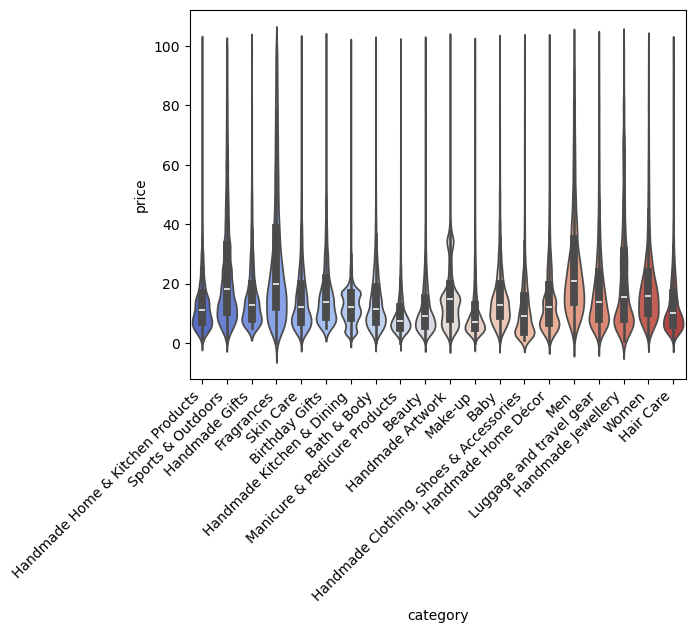

In [31]:
# create violin plot

sns.violinplot(data=filtered_df, x='category', y='price', palette="coolwarm")

plt.xticks(rotation=45, ha='right')
plt.show()

Based on the violin chart, the product category which has highest median price is eihter Fragrances or Men.

#### 2.2. Bar Charts:

- Create a bar chart comparing the average price of products for the top 10 product categories (based on count).

- Which product category commands the highest average price? Don't filter here by top categories.

In [32]:
top_10_categories = df_cleaned['category'].value_counts().head(10).index
filtered_df_10 = df_cleaned[df_cleaned['category'].isin(top_10_categories)]
filtered_df_10.head(3)


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
82163,89483,B07DLGZ828,Neutrade GoPro 3M Sticky Pads Double Sided Adh...,4.2,3116,6.49,False,0,Sports & Outdoors
82164,89484,B09HGZHXJT,"WOLFANG Action Camera 4K 20MP GA100, Waterproo...",4.2,2594,49.99,False,0,Sports & Outdoors
82167,89487,B08LD4VXGL,FitStill 60M/196FT Waterproof Case for Go Pro ...,4.5,9879,16.98,True,0,Sports & Outdoors


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17144\3550397519.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_df_10, x='category', y='price', palette="coolwarm")


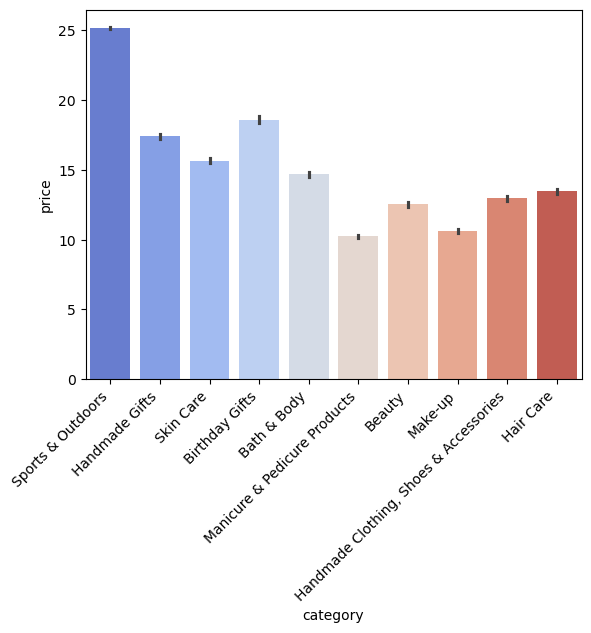

In [33]:
sns.barplot(data=filtered_df_10, x='category', y='price', palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.show()

Sports and Outdoors commands the highest average price.

#### 2.3. Box Plots:

- Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.

- Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17144\1615477674.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df_10, x='category', y='stars', palette="coolwarm")


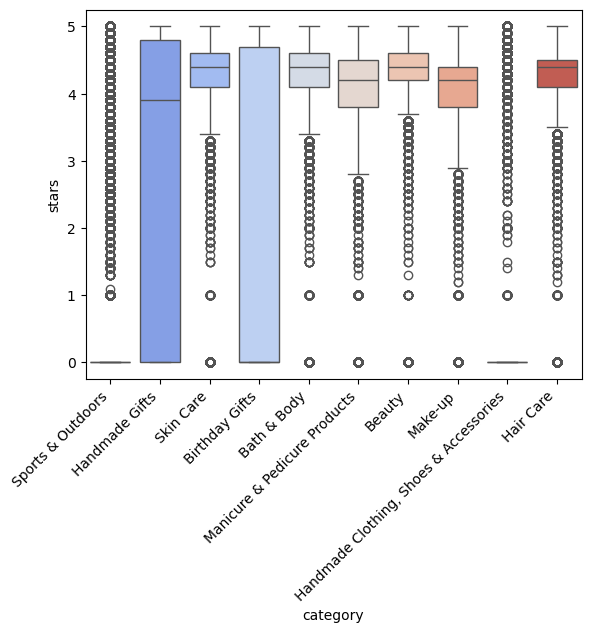

In [34]:
sns.boxplot(data=filtered_df_10, x='category', y='stars', palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.show()


Category which tends to receive the highest median rating from customers is either skin care, bath & body, beauty, or hair care.

## Part 3: Investigating the Interplay Between Product Prices and Ratings

Objective: Analyze how product ratings (stars) correlate with product prices.

#### 3.1. Correlation Coefficients:

- Calculate the correlation coefficient between price and stars.

- Is there a significant correlation between product price and its rating?

In [35]:
# Calculating the Pearson correlation coefficient between 'price' and 'stars' columns
correlation = round(df_cleaned['price'].corr(df_cleaned['stars']),2)
correlation

-0.08

p = -0.08 close to 0, which means that there is no correlation. 

#### 3.2. Visualizations:

- Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?

- Use a correlation heatmap to visualize correlations between all numerical variables.

- Examine if product prices typically follow a normal distribution using a QQ plot.

<Axes: xlabel='stars', ylabel='price'>

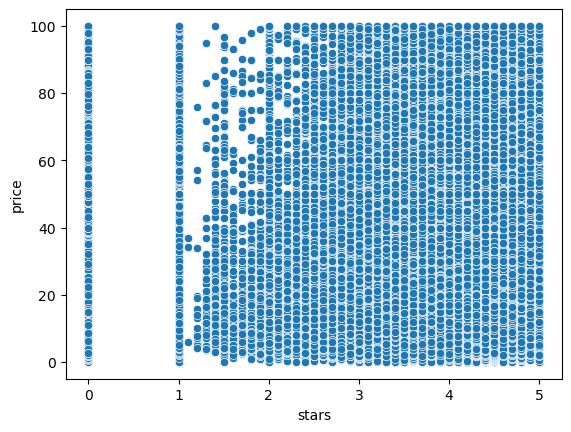

In [36]:
# Scatter plot

sns.scatterplot(data=df_cleaned, x='stars', y='price')


In [38]:
df_cleaned.dtypes

uid                    int64
asin                  object
title                 object
stars                float64
reviews                int64
price                float64
isBestSeller            bool
boughtInLastMonth      int64
category              object
dtype: object

In [39]:
df_number = df_cleaned.select_dtypes("number")
df_number.columns

Index(['uid', 'stars', 'reviews', 'price', 'boughtInLastMonth'], dtype='object')

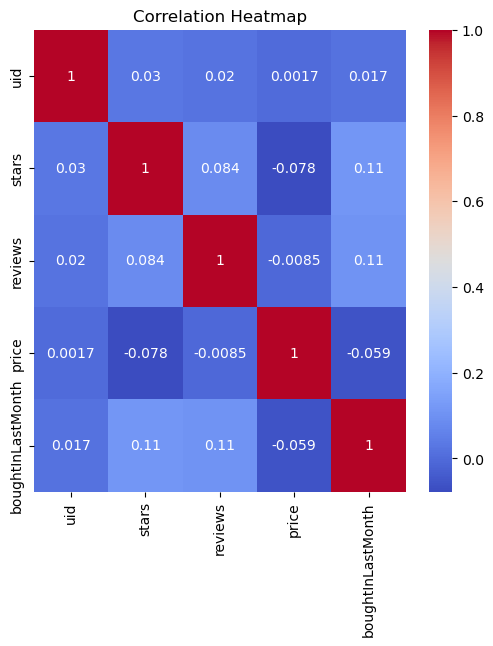

In [40]:
# Heatmap

correlation_matrix = df_number.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(6, 6))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap")
plt.show()

#### Bonus:

- Do the same analysis without taking out the outliers. What are your insights?

In [41]:
# Calculating the Pearson correlation coefficient between 'price' and 'stars' columns
correlation = round(df['price'].corr(df['stars']),2)
correlation

-0.12

<Axes: xlabel='stars', ylabel='price'>

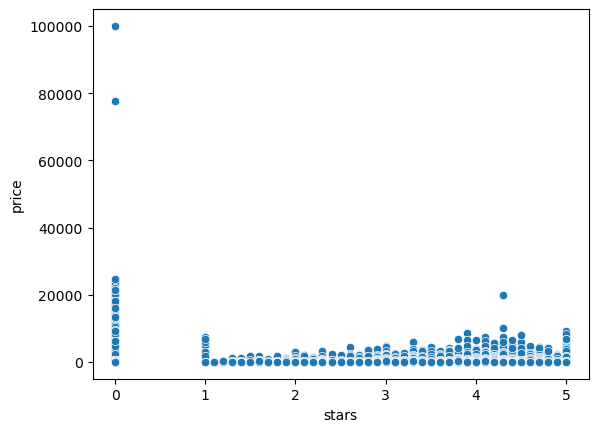

In [42]:
# Scatter plot

sns.scatterplot(data=df, x='stars', y='price')

In [43]:
df_number_2 = df.select_dtypes("number")
df_number_2.columns

Index(['uid', 'stars', 'reviews', 'price', 'boughtInLastMonth'], dtype='object')

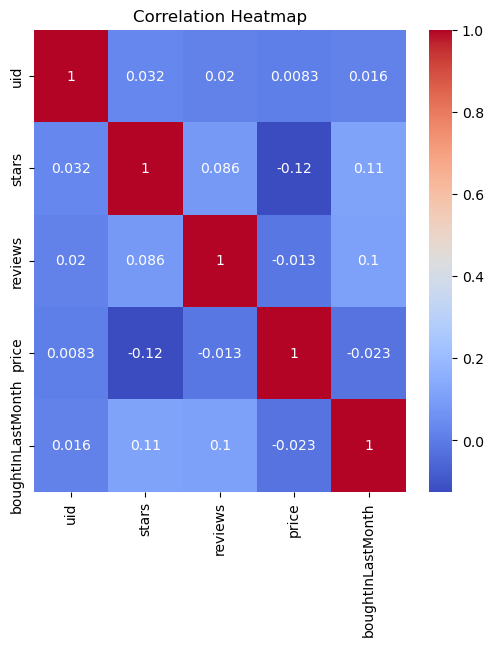

In [44]:
# Heatmap

correlation_matrix = df_number_2.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(6, 6))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap")
plt.show()